# Groundwater Flow Induced by Topography

The darcy flow solver, ``uw.systems.SteadyStateDarcyFlow``, can solve for ground-water flow induced by an imposed pressure-gradient. In this example we show how groundwater flow beneath hetereogeneous topography can be modelled in each of these two ways.

A simple 2D hill model is set up with 2 layers, which are assigned hydraulic properties. 

The model requires a _uniform_ condunctivity in each cell, so a weighted average is calculated to keep cells uniform whilst also maintaining lateral continuity of the layers.

This model highlights how fluid flows through a layer that thins in the centre, where the flow is driven by the topography.


In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
uw.utils.matplotlib_inline()

## Set up the mesh

Initialise a Q1 finite element mesh and mesh variables

In [2]:
deformedmesh = True

elementType = "Q1"
resX = 256
resY = 64
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (0., -12000.), 
                                 maxCoord    = (30000., 0.)) 

gwHydraulicHeadField       = mesh.add_variable( nodeDofCount=1 )
hydraulicDiffusivityField  = mesh.add_variable( nodeDofCount=1 )
velocityField              = mesh.add_variable(nodeDofCount=2)

## Deform mesh to surface topography

We make a  hill using a defined wavelength

In [3]:
xcoords = np.linspace(0,30000,resX)
ycoords = np.linspace(-12000,0,resY)

# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -0.5

def topo_coords(x, hillsize, hillwavelength):
    return hillsize*x/4*np.cos(x*hillwavelength*np.pi)
    

In [4]:
# Set up topography
hillsize = 0.5
hillwavelength = 1.0/26000.0

# pick depth above which to deform mesh
ydeform = -10000.

yCoordFn = uw.function.input()[1]
xCoordFn = uw.function.input()[0]

# ramp option
ydel = hillsize  * (xCoordFn )/4. * uw.function.math.cos(xCoordFn * hillwavelength * np.pi)

if deformedmesh:
    with mesh.deform_mesh():
        for i in range(len(mesh.data[:])):
            y = mesh.data[i,1]
            if y >= ydeform:
                delY = ydel.evaluate((mesh.data[i,0],mesh.data[i,1])) #0.1 * (mesh.data[i,0] + 1.)/2.
                dY = (y - ydeform)/(-ydeform) * delY

                mesh.data[i,1] += dY


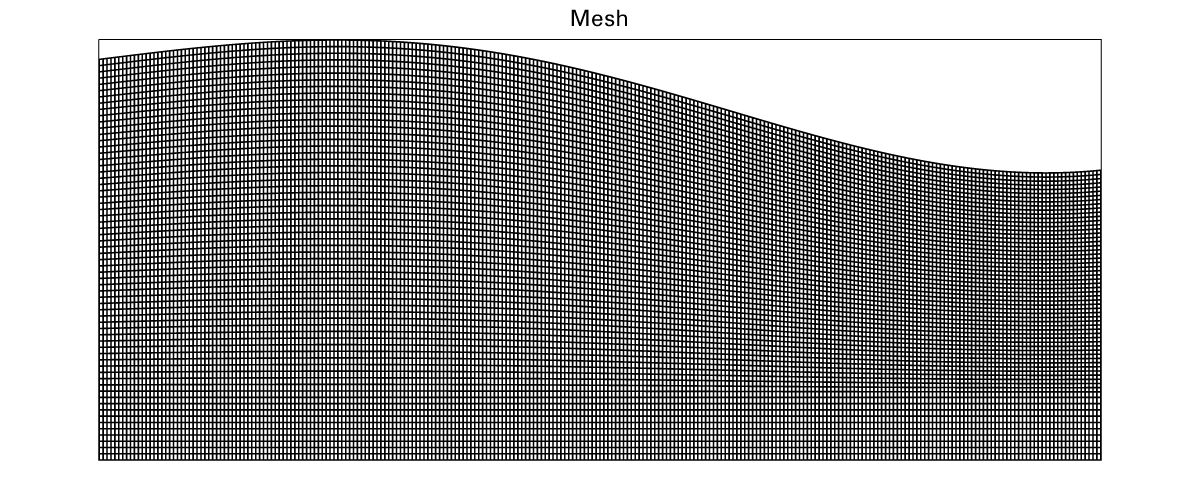

In [5]:
figMaterial = vis.Figure( figsize=(1200,500), title="Mesh" )
figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()

## Set up the types of boundary conditions

We'll set the left, right and bottom walls such that flow cannot pass through them, only parallel.
In other words for hydraulic head $h$:

$ \frac{\partial h}{\partial x}=0$ : left and right walls

$ \frac{\partial h}{\partial y}=0$ : bottom wall

This is only solvable if there is topography or a hydraulic head upper BC.

In [6]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
topWall = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]


gwHydraulicHeadBC = uw.conditions.DirichletCondition( variable        = gwHydraulicHeadField, 
                                                      indexSetsPerDof = ( topWall   ) )

# assign the hydraulic head upper BC to match the mesh
gwHydraulicHeadField.data[:] = yCoordFn.evaluate(mesh)

*Set initial conditions and the values of the boundary conditions. Because the upper BC is a dirichlet condition, the upper wall is constrained to the value we set now. For the rest of the domain, it is helpful to set an increasing groundwater pressure gradient, but the values will be changed during the solution.*

## Set up particle swarm

Each cell contains particles that must be assigned isotropic thermal and hydralic properties. 

As each cell needs a uniform hydraulic conductivity a weighted average is applied after the material layers and properties have been assigned

In [9]:
GPC = 3

swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=GPC)
swarm.populate_using_layout( layout=swarmLayout )

In [10]:
materialIndex        = swarm.add_variable( dataType="int",    count=1 )
swarmVelocity        = swarm.add_variable( dataType="double", count=2 )
hydraulicDiffusivity = swarm.add_variable( dataType="double", count=1 )

materialPorous        = 0
materialImpermeable   = 1

xCoordFn = uw.function.input()[0]
yCoordFn = uw.function.input()[1]

conditions = [ (yCoordFn > -0.5, materialPorous),
               (xCoordFn < -1. , materialPorous),
               (True , materialImpermeable )]


# materialIndex.data[:]  = uw.function.branching.conditional( conditions ).evaluate(swarm)

## create a layer that thins towards the centre

In [11]:
x = np.arange(mesh.minCoord[0], mesh.maxCoord[0])
layer_thickness = 500*(np.cos(x/5000)+1.2)
f = interpolate.interp1d(x, (mesh.minCoord[1] / 2) - layer_thickness)

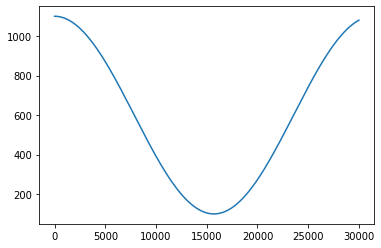

In [12]:
import matplotlib.pyplot as plt
plt.plot(x, layer_thickness)

## Assign material properties

Each 'lithology' is assigned a material index belonging to each particle. Starting values of the hydraulic diffusivity are provided.

In [13]:
### initially set all values in the domain
materialIndex.data[:] = 1
hydraulicDiffusivity.data[:] = 1e-12


### add layer that thins in the centre
materialIndex.data[:][(swarm.data[:,1] < (mesh.minCoord[1] / 2)) & (swarm.data[:,1] > f(swarm.data[:,0]))] = 3

### assign the thinning layer a different hydraulic diffusivity to the rest of the domain
hydraulicDiffusivity.data[materialIndex.data[:] == 3] = 1e-9




In [14]:
### calculates a weighted average of the hydraulic conductivity for each cell

hydraulicDiffusivity.data[:,0] = np.repeat((np.average((np.split(hydraulicDiffusivity.data[:,0], np.unique(swarm.owningCell.data[:,0], return_index = True)[1])[1:]), axis=1)), GPC**mesh.dim)


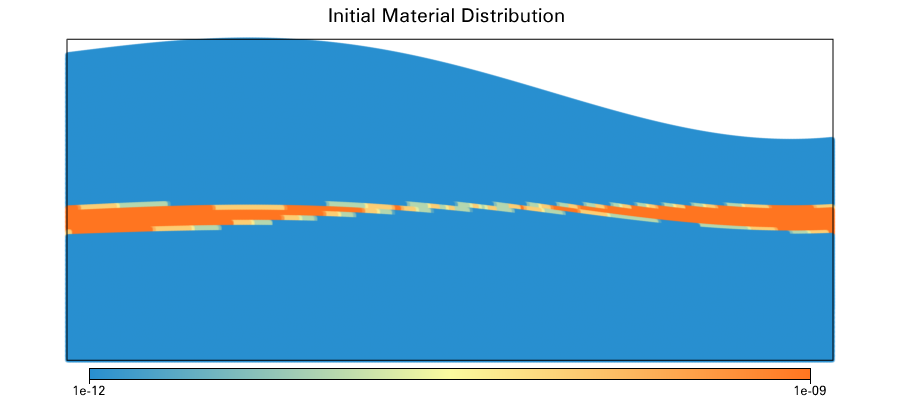

In [15]:
figMaterial = vis.Figure( figsize=(900,400), title="Initial Material Distribution" )
figMaterial.append( vis.objects.Points(swarm, hydraulicDiffusivity, pointSize=6.0) )
# figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()
        
        


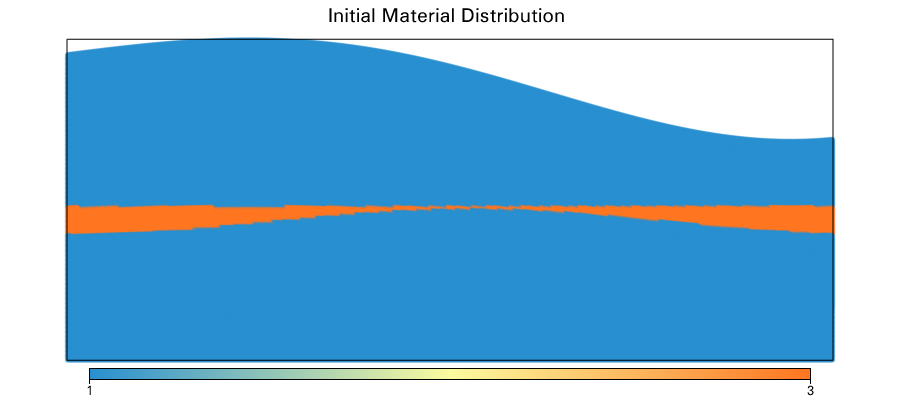

In [16]:
figMaterial = vis.Figure( figsize=(900,400), title="Initial Material Distribution" )
figMaterial.append( vis.objects.Points(swarm, materialIndex, pointSize=6.0) )
# figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()


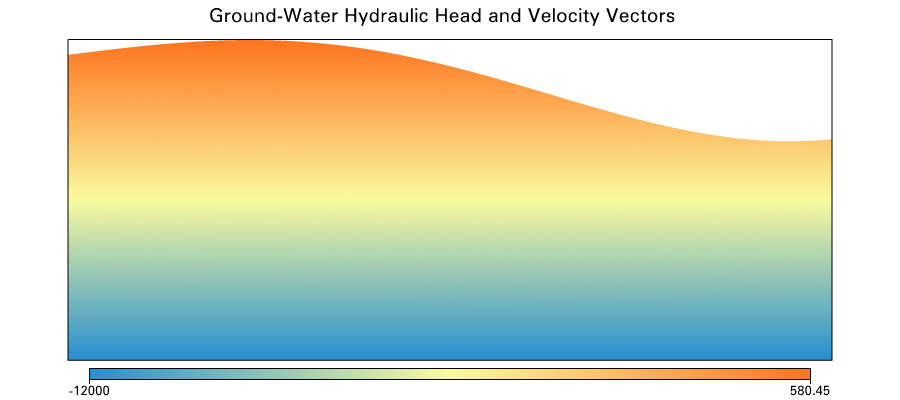

max velocity = 0.0


In [17]:
figMaterial = vis.Figure( figsize=(900,400),title="Ground-Water Hydraulic Head and Velocity Vectors" )
figMaterial.append(vis.objects.Surface(mesh, gwHydraulicHeadField, onMesh=True))
scale = 0.03
figMaterial.append(vis.objects.VectorArrows(mesh,velocityField,scaling=1,arrowHead=0.3))
figMaterial.show()

print("max velocity = {}".format(np.abs(velocityField.data).max()))

In [18]:
# # map diffusivity field using the material index

# for i, index in enumerate(matIndex):
#     mask_index = materialIndex.data == index
#     hydraulicDiffusivity.data[mask_index] = matDiffusivity[i]
    
# # project from swarm to the mesh
# hydproj = uw.utils.MeshVariable_Projection(hydraulicDiffusivityField,hydraulicDiffusivity,swarm)
# hydproj.solve()


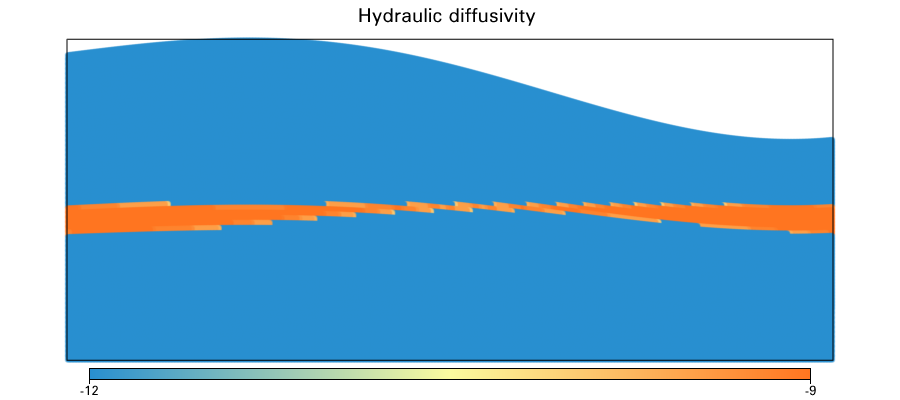

In [19]:
figMaterial = vis.Figure( figsize=(900,400), title="Hydraulic diffusivity" )
figMaterial.append( vis.objects.Points(swarm, uw.function.math.log10(hydraulicDiffusivity), pointSize=6.0) )
figMaterial.show()

*Setup groundwater equations*

In [20]:

gwadvDiff = uw.systems.SteadyStateDarcyFlow(velocityField=velocityField,
                                            pressureField = gwHydraulicHeadField, 
                                            fn_diffusivity = hydraulicDiffusivity,
                                            conditions=[gwHydraulicHeadBC],
                                            fn_bodyforce=(0., 0.),
                                            voronoi_swarm=swarm,
                                            swarmVarVelocity=swarmVelocity)


gwsolver = uw.systems.Solver(gwadvDiff)

/opt/venv/lib/python3.8/site-packages/underworld/systems/_darcyflow.py:123: UserWarning: It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.
  warnings.warn("It is not advised to fill any cell with more than one particle, as the Q1 shape function cannot capture material interfaces. Use at your own risk.")


In [21]:
gwsolver._setup_options(ksp_type='xxxx')
gwsolver.configure('mumps')

In [22]:
gwsolver.solve()


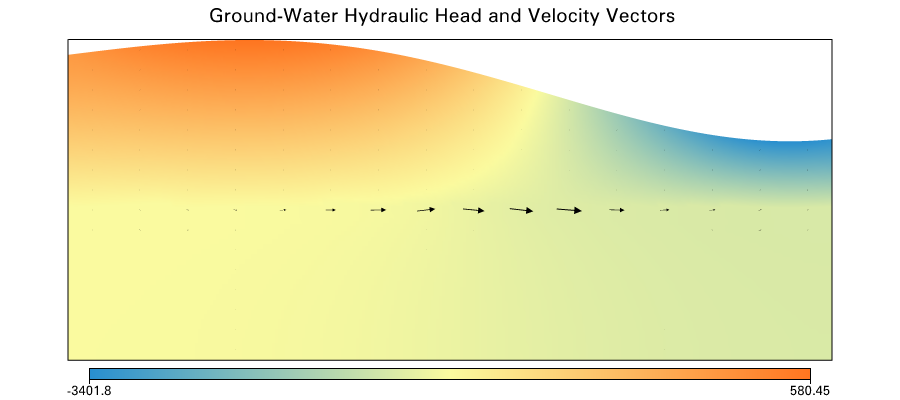

max velocity = 1.3580979723193322e-11


In [23]:
figMaterial = vis.Figure( figsize=(900,400),title="Ground-Water Hydraulic Head and Velocity Vectors" )
figMaterial.append(vis.objects.Surface(mesh, gwHydraulicHeadField, onMesh=True))
scale = 0.03
figMaterial.append(vis.objects.VectorArrows(mesh,velocityField,scaling=1,arrowHead=0.3))
figMaterial.show()

print("max velocity = {}".format(np.abs(velocityField.data).max()))

Here are some metrics, notice that there is a slight change depending on whether or not the deformed mesh / gravity term combination is used.

In [24]:
# If in parallel, every CPU will report these metrics for its own domain.
print("Max horiz. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,0])))
print("Max vert. velocity: %.4e" %np.max(abs(swarmVelocity.data[:,1])))
print("Max pressure: %.4e" %np.max(gwHydraulicHeadField.data[:]))
print("Min pressure: %.4e" %np.min(gwHydraulicHeadField.data[:]))

Max horiz. velocity: 2.6438e-11
Max vert. velocity: 5.2004e-12
Max pressure: 5.8045e+02
Min pressure: -3.4018e+03


In [25]:
print("This model was run successfully to completion using underworld {}".format(uw.__version__))

This model was run successfully to completion using underworld 2.11.0b
